In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
from scipy.interpolate import interp1d

In [3]:
mpk = np.genfromtxt(r'C:/Users/satvi/PhD_thesis/kk.dat')

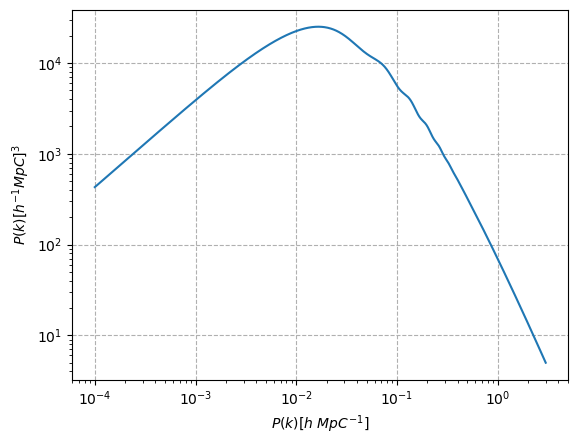

In [4]:
plt.plot(mpk[:,0],mpk[:,1])
plt.grid(linestyle = "dashed")
plt.ylabel('$P(k) [h^{-1}MpC]^3$')
plt.xlabel('$P(k) [h~MpC^{-1}]$')
plt.yscale('log')
plt.xscale('log')

In [282]:
interpolation_func = interp1d(mpk[:,0], mpk[:,1], kind='linear')

# 1D array in k space 

In [5]:
L=10
test = np.arange(int(L/2)+1)
ph = np.random.uniform(-10,10,size = int(L/2))
testing = np.zeros((L),dtype=complex)  
for i in range(1,int(L/2)):
    testing[i]=test[i]+ph[i-1]*1j
    testing[10-i]=test[i]-ph[i-1]*1j
testing[int(L/2)]=test[int(L/2)]+ph[int(L/2)-1]*1j
testing[0]=sum(testing.real)
testing[int(L/2)]=testing[int(L/2)].real

In [6]:
testing #k space  (WORKS!)

array([25.+0.j        ,  1.+7.22813704j,  2.-5.47489946j,  3.-3.04185713j,
        4.+4.90767273j,  5.+0.j        ,  4.-4.90767273j,  3.+3.04185713j,
        2.+5.47489946j,  1.-7.22813704j])

In [7]:
np.fft.ifft(testing,norm="backward")  #not imaginary

array([ 5.        +0.j,  1.64611977+0.j,  2.34464274+0.j, -0.96235938+0.j,
        1.76442091+0.j,  2.4       +0.j,  3.23557909+0.j,  5.65678657+0.j,
        2.65535726+0.j,  1.25945304+0.j])

# 2D array in k space whose ifft is real

In [1005]:
def k_grid_fft(length):
    l_by_2 = int(length/2)
    k_grid = np.zeros((length,length))

    x_values = np.linspace(2*np.pi,l_by_2*2*np.pi,l_by_2)  #creating uniform x grid
    k_val = 2*np.pi/x_values                               #creating associated k values
    k_values = np.concatenate([k_val,[0]])
    k_val_fft = np.concatenate([k_values[::-1],-k_values[1:l_by_2]])

    #setting k values in the 2d k grid

    for i in range(length): 
        for j in range(length):
            k_grid[i,j] = np.sqrt(k_val_fft[i]**2 + k_val_fft[j]**2)
    k_grid[0,0] = 1.0  #adding a 1 to the zeroth value for interpolation, will modify it later anyways (can put any value here)
    
    return k_grid

In [1006]:
def delta_k_array(length):
    
    l_by_2 = int(length/2)
    k_grid = k_grid_fft(length)
    
    p_k_fft = interpolation_func(k_grid)
    del_k_fft = np.zeros((length,length))

    #Creating a larger 2d array with the real part of the delta_k according to numpy convention
    for i in range(0,l_by_2+1):
        for j in range(0,l_by_2+1):
            if(i!=0 or j!=0):
                del_k_fft[i,j] = np.random.rayleigh(scale = np.sqrt(p_k_fft[i,j]))
                if(i>0 and j>0):
                    del_k_fft[length-i,length-j]=del_k_fft[i,j]
                    del_k_fft[length-i,j] = del_k_fft[i,j]
                    del_k_fft[i,length-j] = del_k_fft[i,j]
                if(i==0 and j>0 and j<l_by_2):
                    del_k_fft[i,length-j]=del_k_fft[i,j]
                if(j==0 and i>0 and i<l_by_2):
                    del_k_fft[length-i,j]=del_k_fft[i,j]
                    
    #Doing the same conjugate convention for the imaginary part of the delta_k field to get real transformed values

    phase = np.zeros((length,length))
    p=np.exp(np.random.uniform(0,2*np.pi,size=((length,l_by_2+1))))
    ph = p *(del_k_fft[:length,:l_by_2+1])
    for i in range(0,l_by_2+1):
        for j in range(0,l_by_2+1):
            if(i>0 and j==0 and i<l_by_2):
                phase[i,j] = ph[i,j]
                phase[length-i,j]=-ph[i,j]

            if(j>0 and i==0 and j<l_by_2):
                phase[i,j] = ph[i,j]
                phase[i,length-j]=-ph[i,j]

            if(i>0 and j>0):
                phase[i,j] = ph[i,j]
                phase[length-i,length-j] = -ph[i,j]


                if(i<l_by_2 and j<l_by_2):
                    phase[i+l_by_2,j] = ph[l_by_2+i,j]
                    phase[l_by_2-i,length-j] = - phase[i+l_by_2,j]


    phase[l_by_2,l_by_2] = 0.0
    
    delta_k_fft = del_k_fft + phase*1j
    k_grid[0,0]=0 #restoring original values
    return(delta_k_fft, k_grid)


In [1007]:
np.set_printoptions(linewidth=400)
np.set_printoptions(precision=4)
length = 200
delta_k ,k_grid= delta_k_array(length)

In [1008]:
test=(np.fft.ifft2(delta_k,norm='backward'))
np.max(test.imag),np.min(test.imag)

(4.565065361560442e-13, -4.392172624982463e-13)

Text(0.5, 1.0, 'Density field using Rayleigh sampling')

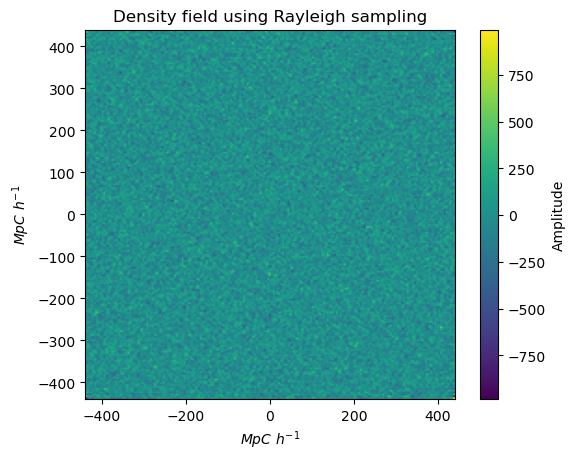

In [1009]:
trunc_test = test[1:length,1:length]
plt.imshow((trunc_test.real), extent=[-440,440, -440, 440],cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')  # Add a colorbar with label
plt.xlabel('$MpC~h^{-1}$')  # x-axis label (if you have x-axis values)
plt.ylabel('$MpC~h^{-1}$')  # y-axis label (if you have y-axis values)
plt.title('Density field using Rayleigh sampling')  # Plot title

Text(0.5, 0, '$\\delta$')

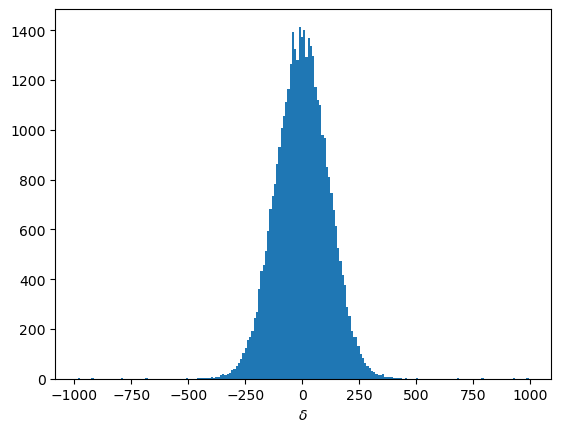

In [1010]:
vals=plt.hist(trunc_test.real.flatten(), bins = 200)
plt.xlabel("$\delta$")

# White noise generation

In [1011]:
white_noise = np.random.normal(loc=0,scale=1,size=length**2).reshape(length,length)

In [1012]:
k_grid=k_grid_fft(length)  #00 value is set to 1, should be 0

del_k = interpolation_func(k_grid)    #Power spectra values for the k grid           

white_noise_fft = np.fft.fft2(white_noise)

In [1013]:
#convolute in k space

delta_k_conv = white_noise_fft * np.sqrt(interpolation_func(k_grid))

delta_k_conv[0,0] = 0   #setting dc component to zero

In [1014]:
delta_x_conv = np.fft.ifft2(delta_k_conv)   #converting back to real space

Text(0.5, 1.0, 'Generated by Convolving correlations with white noise')

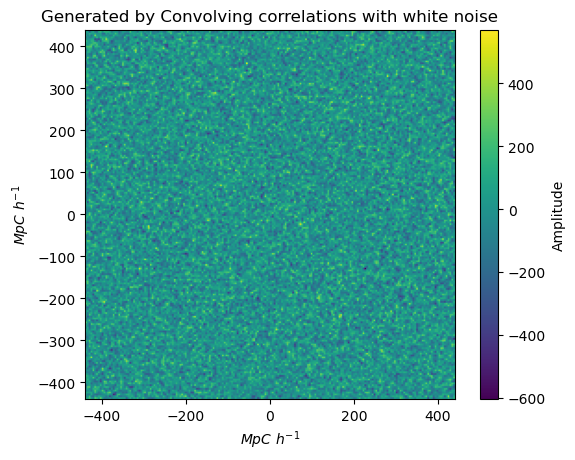

In [1015]:
plt.imshow(delta_x_conv.real)
plt.imshow((delta_x_conv.real), extent=[-440,440, -440, 440],cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')  # Add a colorbar with label
plt.xlabel('$MpC~h^{-1}$')  # x-axis label (if you have x-axis values)
plt.ylabel('$MpC~h^{-1}$')  # y-axis label (if you have y-axis values)
plt.title("Generated by Convolving correlations with white noise")

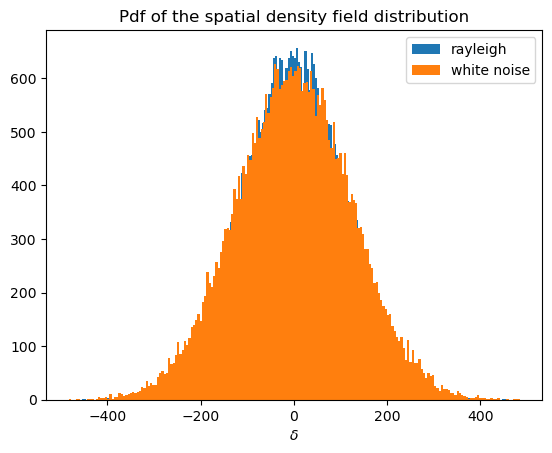

In [1016]:
trunc_test1 = trunc_test[np.abs(trunc_test)<500]
trunc_delta_x_conv = delta_x_conv[1:length,1:length]
trunc_delta_x_conv1 = trunc_delta_x_conv[np.abs(trunc_delta_x_conv)<500]

vals=plt.hist(trunc_test1.real.flatten(), bins = 200,label = 'rayleigh')
histval=plt.hist(trunc_delta_x_conv1.real.flatten(),bins = 200,label = 'white noise')
plt.xlabel("$\delta$")
plt.title("Pdf of the spatial density field distribution")
plt.legend()

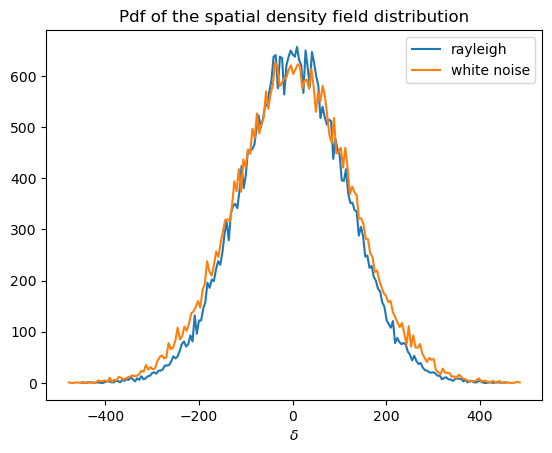

In [1020]:
plt.plot(vals[1][1:],vals[0],label = 'rayleigh')
plt.plot(histval[1][1:],histval[0],label = 'white noise')
plt.xlabel("$\delta$")
plt.title("Pdf of the spatial density field distribution")
plt.legend()
plt.savefig("Pdf of the spatial density field distribution")